In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import IPython.display as display
import matplotlib.pyplot as plt
import pathlib
import random
import numpy as np

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
# You need to download the prepared data and unzip the file in current path('./')
data_root = pathlib.Path('./oregon_wildlife/')

# print the subfolders.
print('classes:')
for item in data_root.iterdir():
    print(item)
    
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
all_image_paths = shuffle(all_image_paths, random_state=1)
all_image_paths = [path for path in all_image_paths if path[-3:] not in ('gif','bmp')]
image_count = len(all_image_paths)
print('\ntotal img num:', image_count)

classes:
oregon_wildlife/bald_eagle
oregon_wildlife/black_bear
oregon_wildlife/cougar
oregon_wildlife/deer
oregon_wildlife/nutria
oregon_wildlife/raccoon
oregon_wildlife/raven
oregon_wildlife/red_fox
oregon_wildlife/sea_lions
oregon_wildlife/virginia_opossum

total img num: 7168


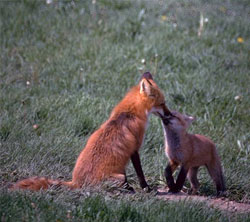

red_fox


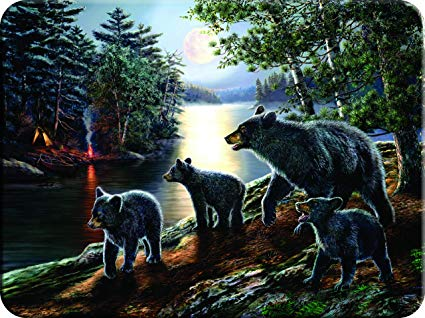

black_bear


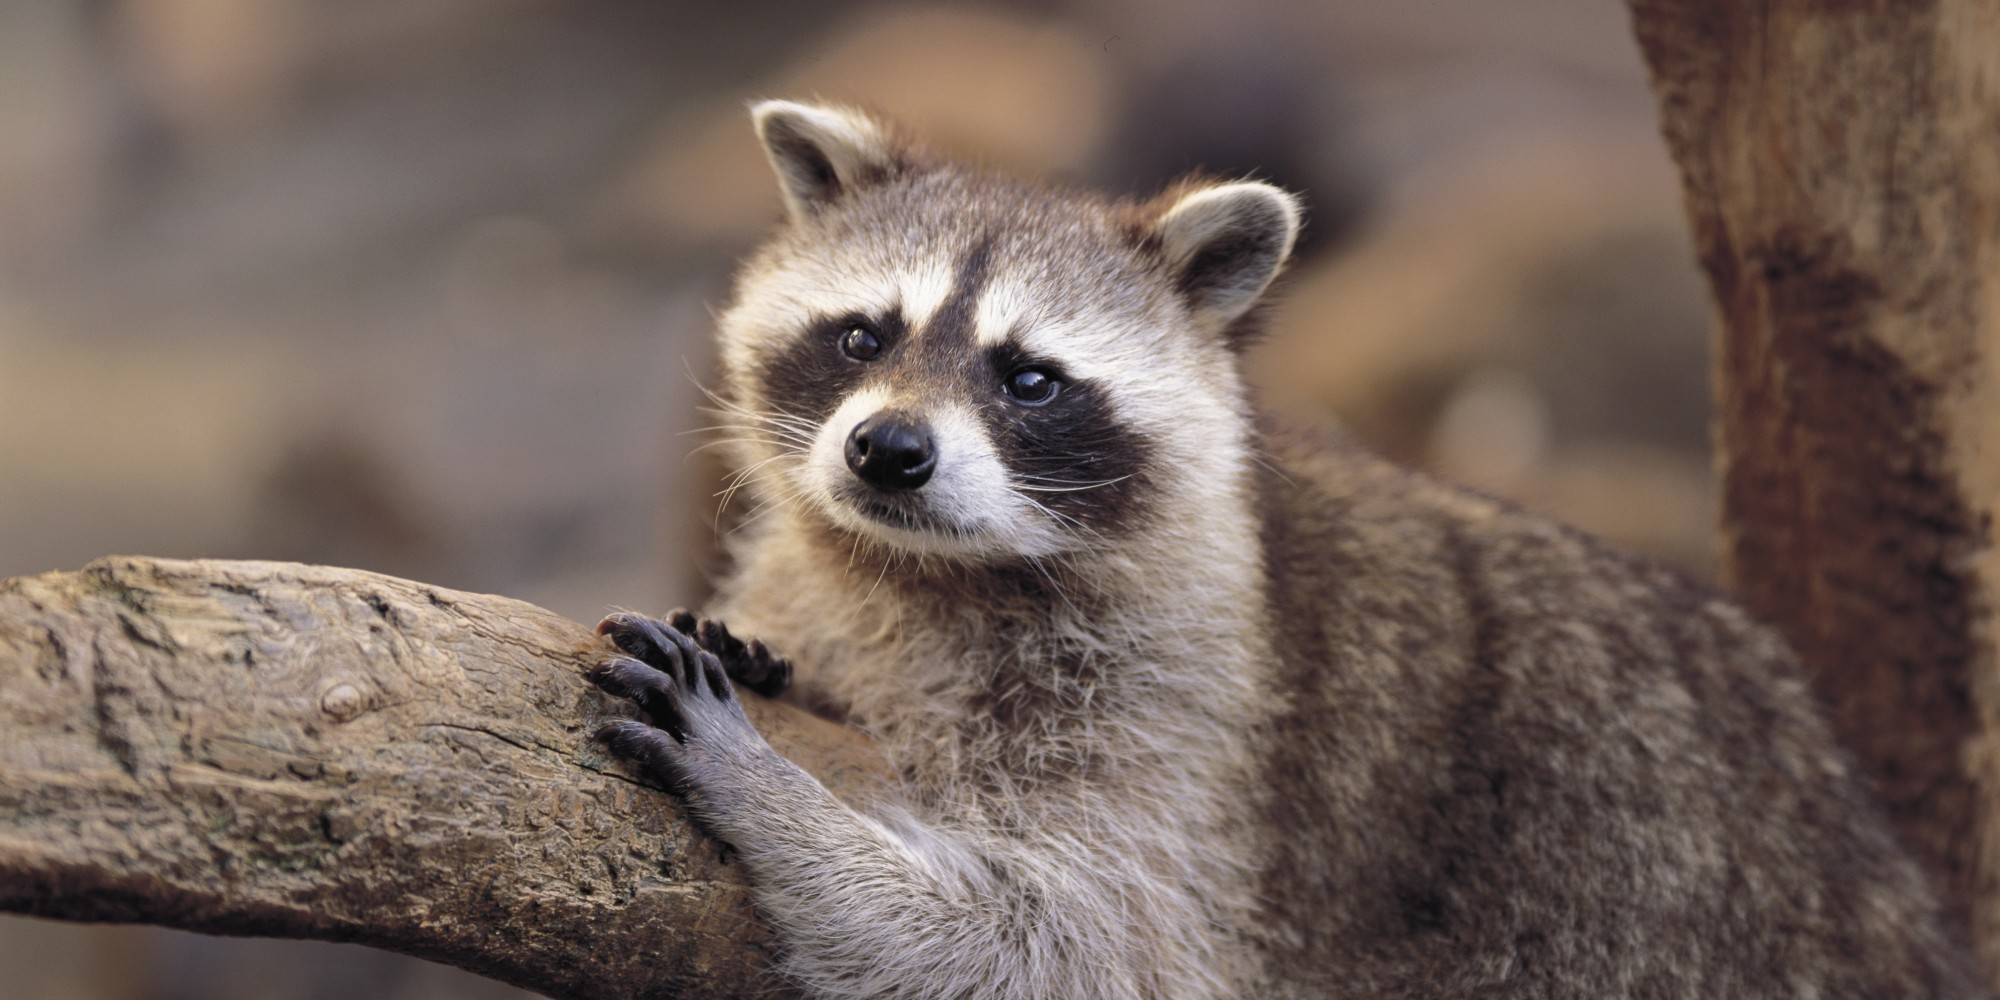

raccoon


In [4]:
# random showing 3 iamges for you
for n in range(3):
    image_path = random.choice(all_image_paths)
    display.display(display.Image(image_path, width=200, height=200))
    print(image_path.split('/')[-2])

In [5]:
# get the labels
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
# total labels
n_classes = len(label_names)
print(label_names)

['bald_eagle', 'black_bear', 'cougar', 'deer', 'nutria', 'raccoon', 'raven', 'red_fox', 'sea_lions', 'virginia_opossum']


In [6]:
# get the mapping dict
label_to_index = dict((name, index) for index,name in enumerate(label_names))
index_to_label = dict((index, name) for index,name in enumerate(label_names))
print(label_to_index)

{'bald_eagle': 0, 'black_bear': 1, 'cougar': 2, 'deer': 3, 'nutria': 4, 'raccoon': 5, 'raven': 6, 'red_fox': 7, 'sea_lions': 8, 'virginia_opossum': 9}


In [7]:
# get the label data
all_image_labels = [label_to_index[pathlib.Path(path).parent.name] for path in all_image_paths]
print("First 10 labels indices: ", all_image_labels[:10])

First 10 labels indices:  [8, 5, 2, 5, 0, 2, 1, 0, 1, 0]


In [8]:
# Create training and validation sets using an 80-20 split
img_path_train, img_path_val, label_train, label_val = train_test_split(all_image_paths,
                                all_image_labels,test_size=0.2,random_state=0)
print('training data: %d'%(len(img_path_train)))
print('testing data: %d'%(len(img_path_val)))

training data: 5734
testing data: 1434


In [9]:
# You will use these setting in your code, pls do not modify these 4.
IMAGE_SIZE_CROPPED = 224
IMAGE_HEIGHT = 300
IMAGE_WIDTH = 300
IMAGE_DEPTH = 3


# feel free to modify these Settings.
# BUFFER_SIZE = 10000
# BATCH_SIZE = 32

BUFFER_SIZE = 100
BATCH_SIZE = 4

In [10]:
# parse training data
def map_fun(image,label):
    image = tf.reshape(image,[IMAGE_DEPTH,IMAGE_HEIGHT,IMAGE_WIDTH])
#     image = tf.divide(tf.cast(tf.transpose(image,[1,2,0]),tf.float32),255.0)
    image = tf.cast(tf.transpose(image,[1,2,0]),tf.float32)
    image = tf.divide(image ,255.0)
    label = tf.one_hot(label,10)
    distorted_image = tf.image.random_crop(image, [IMAGE_SIZE_CROPPED,IMAGE_SIZE_CROPPED,3])
    distorted_image = tf.image.random_flip_left_right(distorted_image)
    distorted_image = tf.image.random_brightness(distorted_image, max_delta=63)
    distorted_image = tf.image.random_contrast(
        distorted_image, lower=0.2, upper=1.8)
    distorted_image = tf.image.per_image_standardization(distorted_image)
    return distorted_image, label

# parse testing data
def map_fun_test(image,label):
    image = tf.reshape(image,[IMAGE_DEPTH,IMAGE_HEIGHT,IMAGE_WIDTH])
    image = tf.cast(tf.transpose(image,[1,2,0]),tf.float32)
    image = tf.divide(image ,255.0)
    label = tf.one_hot(label,10)
    distorted_image = tf.image.resize_with_crop_or_pad(image, IMAGE_SIZE_CROPPED,IMAGE_SIZE_CROPPED)
    distorted_image = tf.image.per_image_standardization(distorted_image)
    return distorted_image, label

In [11]:
# # loda images
# def load_image(image_path, label):
#     img = tf.io.read_file(image_path)
#     img = tf.image.decode_jpeg(img, channels=IMAGE_DEPTH)
#     img = tf.image.resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH))
#     img = tf.cast(img, tf.float32)
#     img = tf.divide(img,255.0)
#     return img, label

In [12]:
# # the dataset objects we prepared for you
# dataset_train = tf.data.Dataset.from_tensor_slices((img_path_train,label_train))
# dataset_train = dataset_train.map(load_image)

# dataset_val = tf.data.Dataset.from_tensor_slices((img_path_val,label_val))
# dataset_val = dataset_val.map(load_image)

In [13]:
# The following functions can be used to convert a value to a type compatible with tf.Example.

def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [14]:
# Create a description of the features.
feature_description = {
    'image': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'label': tf.io.FixedLenFeature([], tf.int64, default_value=0),
}

def _parse_function(example_proto):
  # Parse the input `tf.Example` proto using the dictionary above.
    feature_dict = tf.io.parse_single_example(example_proto, feature_description)
    img = tf.io.decode_jpeg(feature_dict['image'], channels=IMAGE_DEPTH)
    label = tf.cast(feature_dict['label'], tf.int64)
    img = tf.image.resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH))
    img, label = map_fun(img, label)
    return img, label

def _parse_function_test(example_proto):
  # Parse the input `tf.Example` proto using the dictionary above.
    feature_dict = tf.io.parse_single_example(example_proto, feature_description)
    img = tf.io.decode_jpeg(feature_dict['image'], channels=IMAGE_DEPTH)
    label = tf.cast(feature_dict['label'], tf.int64)
    img = tf.image.resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH))
    img, label = map_fun_test(img, label)
    return img, label

## train to tfrecord

In [15]:
# # Use tf.data API to:
#     # todo1:
#         # write the dataset above to tfrecord
#     # todo2:
#         # read the data from tfrecord you get in Todo1
#     # todo3:
#         # remember to preprocess the data. You can refer to the code in the Cifar10 section.
        
tfrecord_file = "./train.tfrecord"
writer = tf.io.TFRecordWriter(tfrecord_file)

index = [i for i in range(len(img_path_train))]
# np.random.shuffle(index)
for i in range(len(img_path_train)):
    
    image_path = img_path_train[index[i]]
    label = label_train[index[i]]
    img = open(image_path, 'rb').read()


    ex = tf.train.Example(
        features=tf.train.Features(
            feature={
                "image": _bytes_feature(img),
                "label": _int64_feature(label)
            }
        )
    )
    writer.write(ex.SerializeToString())
writer.close()

## val to tfrecord

In [16]:
tfrecord_file = "./val.tfrecord"
writer = tf.io.TFRecordWriter(tfrecord_file)

index = [i for i in range(len(img_path_val))]
# np.random.shuffle(index)
for i in range(len(img_path_val)):
    
    image_path = img_path_val[index[i]]
    label = label_val[index[i]]
    img = open(image_path, 'rb').read()
    ex = tf.train.Example(
        features=tf.train.Features(
            feature={
                "image": _bytes_feature(img),
                "label": _int64_feature(label)
            }
        )
    )
    writer.write(ex.SerializeToString())
writer.close()

In [17]:
train_tfrecord_file = "./train.tfrecord"
dataset_train = tf.data.TFRecordDataset(train_tfrecord_file)

val_tfrecord_file = "./val.tfrecord"
dataset_val = tf.data.TFRecordDataset(val_tfrecord_file)

In [18]:
dataset_train = dataset_train.map(_parse_function)
dataset_train = dataset_train.batch(BATCH_SIZE)
dataset_train = dataset_train.shuffle(BUFFER_SIZE)

dataset_train

<ShuffleDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [19]:
dataset_val = dataset_val.map(_parse_function_test)
dataset_val = dataset_val.batch(BATCH_SIZE)
# dataset_val = dataset_val.shuffle(BUFFER_SIZE)

dataset_val

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)


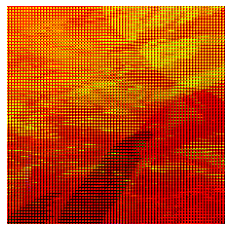

tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(10,), dtype=float32)
(4, 224, 224, 3)
(4, 10)


In [20]:
# show one image here.
for img, label in dataset_train.take(1):
    print(img[0].shape)
#     print(img[0])
    plt.imshow(img[0]) 
    plt.axis('off') 
    plt.show()
    print(label[0])
    print(img.shape)
    print(label.shape)
#     print(index_to_label[label[0].numpy()])

In [21]:
base_model = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling=None,
)
for layer in base_model.layers:
    layer.trainable = False

top_model = models.Sequential()
top_model.add(layers.Flatten())
top_model.add(layers.Dense(4096, activation='relu'))
top_model.add(layers.Dropout(0.5))
top_model.add(layers.Dense(1024, activation='relu'))
top_model.add(layers.Dropout(0.5))
top_model.add(layers.Dense(n_classes, activation='softmax'))

wild_model = tf.keras.Model(inputs=base_model.input, outputs=top_model(base_model.output)) 

In [22]:
wild_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

wild_model.fit(dataset_train, validation_data=dataset_val, epochs=5)

Epoch 1/5
1434/1434 [==============================] - 103s 67ms/step - loss: 3.2183 - accuracy: 0.1125 - val_loss: 2.2987 - val_accuracy: 0.1039
Epoch 2/5
1434/1434 [==============================] - 101s 66ms/step - loss: 2.3181 - accuracy: 0.1025 - val_loss: 2.2993 - val_accuracy: 0.0976
Epoch 3/5
1434/1434 [==============================] - 97s 64ms/step - loss: 2.3131 - accuracy: 0.1062 - val_loss: 2.2995 - val_accuracy: 0.0976
Epoch 4/5
1434/1434 [==============================] - 96s 64ms/step - loss: 2.3149 - accuracy: 0.1059 - val_loss: 2.3023 - val_accuracy: 0.1081
Epoch 5/5
1434/1434 [==============================] - 100s 66ms/step - loss: 2.3100 - accuracy: 0.0998 - val_loss: 2.3008 - val_accuracy: 0.0969
